In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import os

In [5]:
import pysam
import numpy as np
import cPickle as pickle
import pandas as pd

In [6]:
from collections import Counter
from random import randint

In [7]:
import logging
logging.basicConfig(level=logging.INFO)

------------------------

In [8]:
def assign_color():
    
    return (str(randint(0, 255)) + ',' + str(randint(0, 255)) + ',' + str(randint(0, 255)))

In [26]:
def color_read(read, color):
    
    if read.has_tag('RG'):
        read.set_tag('RG', None)
        
    if read.has_tag('YC'):
        read.set_tag('YC', color)
    else:
        read.tags += [('YC', color)]
        
    return

In [16]:
def create_color_map(keys):
    vals = [assign_color() for i in range(len(keys))]
    
    return dict(zip(keys,vals))

In [20]:
def umi_list(in_file):
    
    st = pysam.AlignmentFile(in_file,"rb")
    reads = st.fetch(until_eof=True)
    
    umis = []
    for r in reads:
        umis.append(r.get_tag('XM'))
        
    if umis:
        return list(set(umis))

In [4]:
def color_reads(in_file):
    
    st = pysam.AlignmentFile(in_file,"rb")
    reads = st.fetch(until_eof=True)
    
    # Could be moved to a separate function
    qnames = []
    for r in reads:
        qnames.append(r.query_name)
    
    color_map = create_color_map(set(qnames))
    
    out_file = "%s.colored.bam" % os.path.splitext(in_file)[0]
    colored_reads = pysam.AlignmentFile('tmp.bam', 'wb', template=st)
    
    st.reset()
    reads = st.fetch(until_eof=True)
    for r in reads:
        if r.has_tag('RG'):
            r.set_tag('RG', None)
        color = color_map[r.query_name]
        r.tags += [('YC', color)]
        colored_reads.write(r)

    colored_reads.close()
    pysam.sort("-o", out_file, 'tmp.bam')
    pysam.index(out_file)

In [27]:
def color_umi_groups(in_file):
    
    umis = umi_list(in_file)
    color_map = create_color_map(umis)
    
    out_file = "%s.umi.colored.bam" % os.path.splitext(in_file)[0]
        
    st = pysam.AlignmentFile(in_file,"rb")
    colored_reads = pysam.AlignmentFile('tmp.bam', 'wb', template=st)
    reads = st.fetch(until_eof=True)
    
    for r in reads:
        color_read(r, color_map[r.get_tag('XM')])
        colored_reads.write(r)
        
    colored_reads.close()
    pysam.sort("-o", out_file, 'tmp.bam')
    pysam.index(out_file)

In [28]:
# Test!
color_umi_groups('/data/parastou/Star-Lab/test/NStar10.Aligned.sorted.out.tagged.bam')

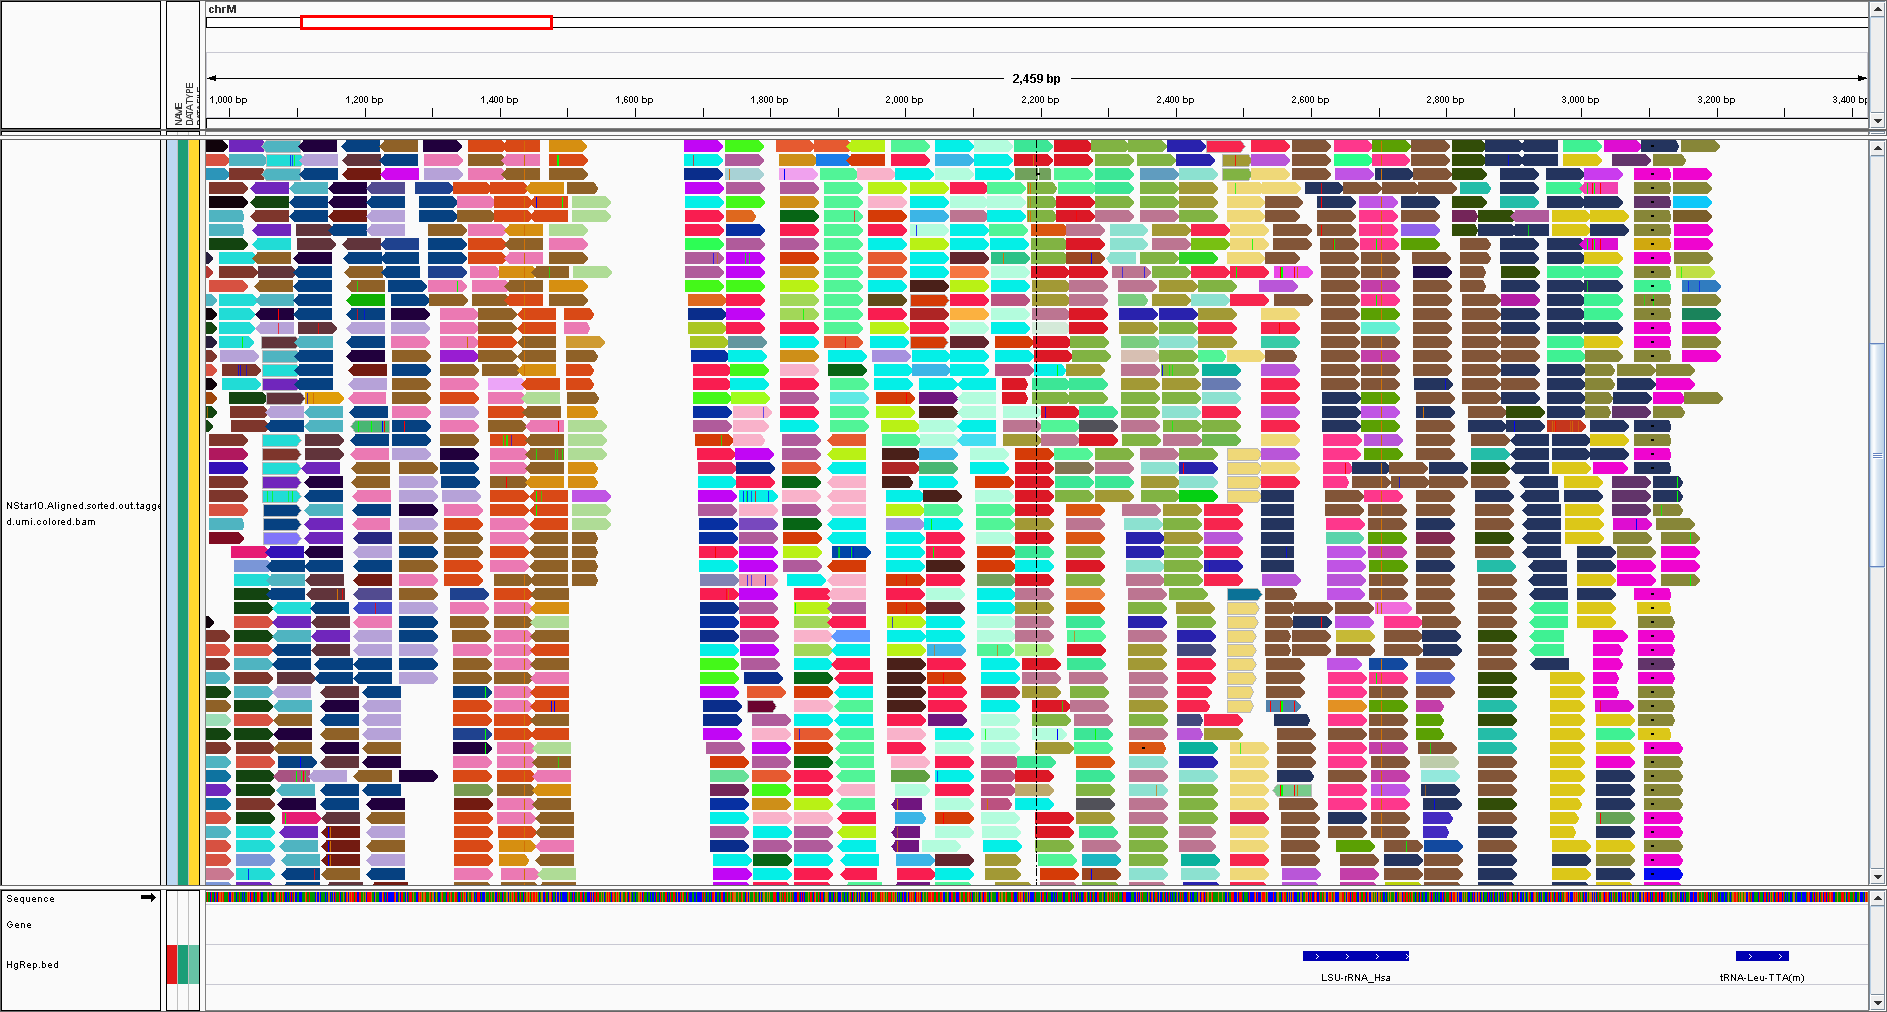

In [1]:
from IPython.display import Image
Image("Plots/colored_umi.png")